# Lab 1: Independent Component Analysis

### Machine Learning 2: March 2016

* The lab exercises should be made in groups of two people.
* The deadline is Sunday, April 10, 23:59.
* Assignment should be sent to t.s.cohen at uva dot nl (Taco Cohen). The subject line of your email should be "[MLPM2016] lab#_lastname1\_lastname2". 
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "[MLPM2016] lab01\_Kingma\_Hu", the attached file should be "lab01\_Kingma\_Hu.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact us.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: test your code and make sure we can run your notebook / scripts!

### Literature
In this assignment, we will implement the Independent Component Analysis algorithm as described in chapter 34 of David MacKay's book "Information Theory, Inference, and Learning Algorithms", which is freely available here:
http://www.inference.phy.cam.ac.uk/mackay/itila/book.html

Read the ICA chapter carefuly before you continue!

### Notation

$\mathbf{X}$ is the $M \times T$ data matrix, containing $M$ measurements at $T$ time steps.

$\mathbf{S}$ is the $S \times T$ source matrix, containing $S$ source signal values at $T$ time steps. We will assume $S = M$.

$\mathbf{A}$ is the mixing matrix. We have $\mathbf{X} = \mathbf{A S}$.

$\mathbf{W}$ is the matrix we aim to learn. It is the inverse of $\mathbf{A}$, up to indeterminacies (scaling and permutation of sources).

$\phi$ is an elementwise non-linearity or activation function, typically applied to elements of $\mathbf{W X}$.

### Code
In the following assignments, you can make use of the signal generators listed below.



In [1]:
%pylab inline

# Signal generators
def sawtooth(x, period=0.2, amp=1.0, phase=0.):
    return (((x / period - phase - 0.5) % 1) - 0.5) * 2 * amp

def sine_wave(x, period=0.2, amp=1.0, phase=0.):
    return np.sin((x / period - phase) * 2 * np.pi) * amp

def square_wave(x, period=0.2, amp=1.0, phase=0.):
    return ((np.floor(2 * x / period - 2 * phase - 1) % 2 == 0).astype(float) - 0.5) * 2 * amp

def triangle_wave(x, period=0.2, amp=1.0, phase=0.):
    return (sawtooth(x, period, 1., phase) * square_wave(x, period, 1., phase) + 0.5) * 2 * amp

def random_nonsingular_matrix(d=2):
    """
    Generates a random nonsingular (invertible) matrix of shape d*d
    """
    epsilon = 0.1
    A = np.random.rand(d, d)
    while abs(np.linalg.det(A)) < epsilon:
        A = np.random.rand(d, d)
    return A

def plot_signals(X):
    """
    Plot the signals contained in the rows of X.
    """
    plt.figure()
    for i in range(X.shape[0]):
        ax = plt.subplot(X.shape[0], 1, i + 1)
        plt.plot(X[i, :])
        ax.set_xticks([])
        ax.set_yticks([])

Populating the interactive namespace from numpy and matplotlib


The following code generates some toy data to work with.

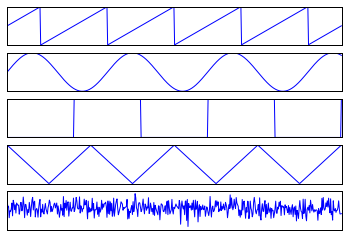

In [2]:
# Generate data
num_sources = 5
signal_length = 500
t = linspace(0, 1, signal_length)
S = np.c_[sawtooth(t), sine_wave(t, 0.3), square_wave(t, 0.4), triangle_wave(t, 0.25), np.random.randn(t.size)].T
plot_signals(S)

### 1.1 Make mixtures (5 points)
Write a function `make_mixtures(S, A)' that takes a matrix of source signals $\mathbf{S}$ and a mixing matrix $\mathbf{A}$, and generates mixed signals $\mathbf{X}$. 

In [3]:
def make_mixtures(S, A):
    """
    Algorithm 34.4: Step 1
    """
    return np.dot(A, S)

In [4]:
# Test
make_mixtures(S, random_nonsingular_matrix(d=len(S)))

array([[  9.28668793e-01,   3.89205943e-01,   5.24499105e-01, ...,
          4.15926240e-01,   4.17153176e-01,   7.14680181e-01],
       [ -5.45838861e-03,  -1.29124935e-03,   1.47640639e-02, ...,
          4.53787868e-01,   4.74123629e-01,   1.85759131e+00],
       [  1.29847207e+00,   2.57296210e-01,   4.61835062e-01, ...,
         -5.58422866e-01,  -5.44368744e-01,   6.98178797e-01],
       [  8.68591571e-02,   7.68566517e-03,   4.79935900e-02, ...,
          2.72834845e-02,   4.65454610e-02,   5.08223101e-01],
       [  3.66203324e-01,  -3.81367865e-01,  -2.30378175e-01, ...,
         -1.07765425e+00,  -1.08042800e+00,   1.50071468e-01]])

### 1.2 Histogram (5 points)
Write a function `plot_histograms(X)` that takes a data-matrix $\mathbf{X}$ and plots one histogram for each signal (row) in $\mathbf{X}$. You can use the numpy `histogram()` function. 

Plot histograms of the sources and the measurements. 
Which of these distributions (sources or measurements) tend to look more like Gaussians? Why is this important for ICA? Can you think of an explanation for this phenomenon?

In [5]:
def plot_histograms(X):
    fig = plt.figure()
    fig.set_size_inches((16, 4))
    for i in range(len(X)):
        ax = plt.subplot(1, len(X), i + 1)
        plt.hist(X[i])
        
    plt.show()

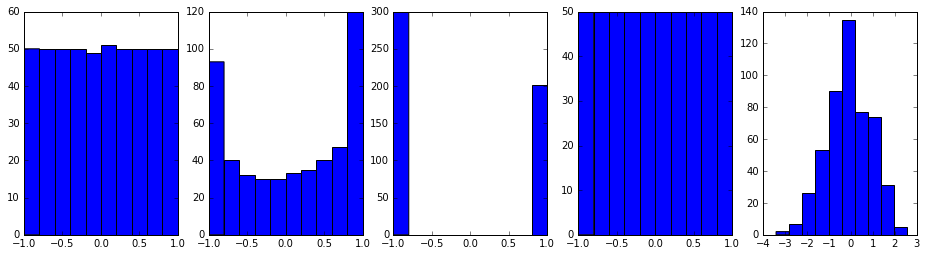

In [6]:
# Histogram of the source
plot_histograms(S)

(5, 5)
(5, 500)
(5, 500)


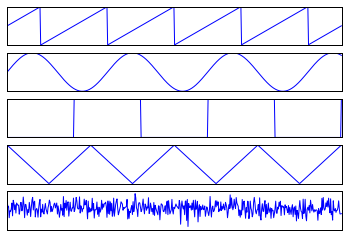

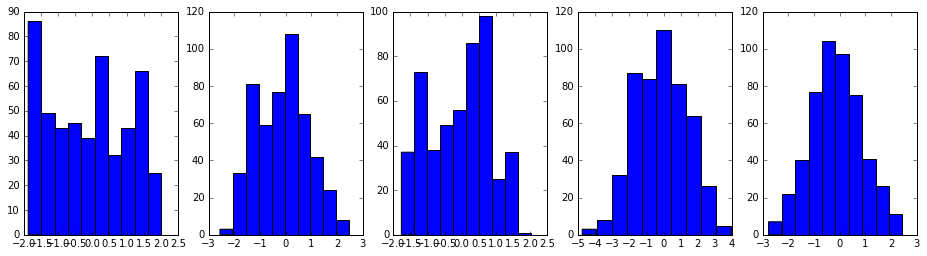

In [7]:
# Histogram of the measurement
A = random_nonsingular_matrix(d=len(S))
M = make_mixtures(S, A)
plot_signals(S)

print A.shape
print S.shape
print M.shape
plot_histograms(M)

### Answer

# TODO: Answer the question

The measurement look more like a Gaussian

### 1.3 Implicit priors (20 points)
As explained in MacKay's book, an activation function $\phi$ used in the ICA learning algorithm corresponds to a prior distribution over sources. Specifically, $\phi(a) = \frac{d}{da} \ln p(a)$. For each of the following activation functions, derive the source distribution they correspond to.
$$\phi_0(a) = -\tanh(a)$$
$$\phi_1(a) = -a + \tanh(a)$$
$$\phi_2(a) = -a^3$$
$$\phi_3(a) = -\frac{6a}{a^2 + 5}$$

The normalizing constant **is not required**, so an answer of the form $p(a) \propto \verb+[answer]+$ is ok.

Plot the activation functions and the corresponding prior distributions. Compare the shape of the priors to the histogram you plotted in the last question.

$$
p(a) = \exp\bigg(\int \phi_i(a)da \bigg)
$$

http://math2.org/math/integrals/more/tanh.htm

$$
p_0(a) = \exp\bigg(-\int tanh(a)da \bigg) \propto \exp\bigg(-\ln\cosh(a)\bigg) \propto \dfrac{1}{cosh(a)}
$$

$$
p_1(a) = \exp\bigg(-\int (a - tanh(a))da \bigg) \propto \exp\bigg(-\dfrac{1}{2}a^2 + \ln\cosh(a)\bigg) \propto \exp\bigg(-\dfrac{1}{2}a^2\bigg)cosh(a)
$$

$$
p_2(a) = \exp\bigg(-\int a^3da\bigg) \propto \exp\bigg(-\dfrac{1}{4}a^4\bigg)
$$

$$
p_3(a) = \exp\bigg(-\int \dfrac{6a}{a^2 + 5} da\bigg) \propto \exp\bigg(-3\ln(a^2+5)\bigg) \propto (a^2+5)^{-3}
$$

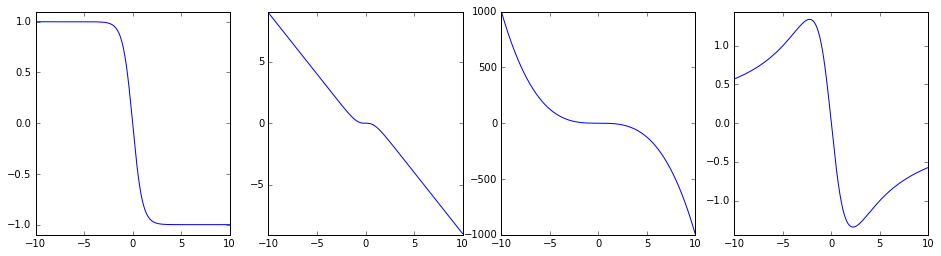

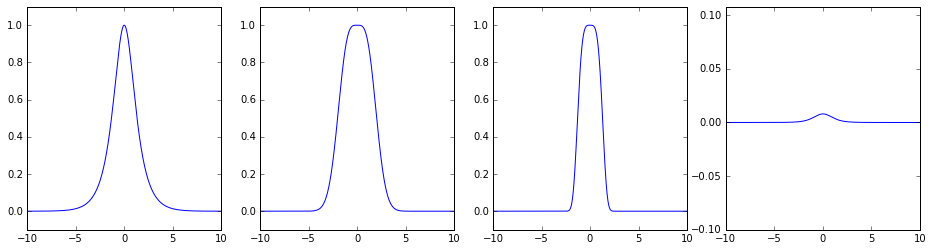

In [8]:
phi0 = lambda a: -np.tanh(a)
phi1 = lambda a: -a + np.tanh(a)
phi2 = lambda a: -a ** 3
phi3 = lambda a: -6 * a/ (a ** 2 + 5)

activation_functions = [phi0, phi1, phi2, phi3]

p0 = lambda a: 1 / np.cosh(a)
p1 = lambda a: np.exp(-0.5 * a ** 2) * np.cosh(a)
p2 = lambda a: np.exp(-0.25 * a ** 4)
p3 = lambda a: (a ** 2 + 5) ** (-3)

prior_dist = [p0, p1, p2, p3]

def plot(functions):
    fig = plt.figure()
    fig.set_size_inches((16, 4))

    a = np.linspace(-10, 10, 1000)

    for i in range(len(functions)):
        ax = plt.subplot(1, len(functions), i + 1)
        output = functions[i](a)
        plt.plot(a, output)
        ax.set_ylim((min(output) - 0.1, max(output) + 0.1))

    plt.show()

# Plotting activation functions
plot(activation_functions)

# Plotting corresponding prior distributions
plot(prior_dist)

### 1.4 Whitening (15 points)
Some ICA algorithms can only learn from whitened data. Write a method `whiten(X)` that takes a $M \times T$ data matrix $\mathbf{X}$ (where $M$ is the dimensionality and $T$ the number of examples) and returns a whitened matrix. If you forgot what whitening is or how to compute it, various good sources are available online, such as http://courses.media.mit.edu/2010fall/mas622j/whiten.pdf

In [9]:
def whiten(X):
    # Zero mean data
    X -= np.mean(X, axis=1, keepdims=True)
    
    # Covariance matrix of X
    Phi = np.cov(X)
    # Eigenvalues and eigenvectors
    Lamb, Phi = np.linalg.eigh(Phi)
    
    Lamb = np.diag(Lamb)
    A = Phi.dot(np.sqrt(np.linalg.inv(Lamb)))
    return A.T.dot(X)
    

In [10]:
# Test
M_whiten = whiten(M)
print M_whiten
print np.cov(M_whiten)

[[ 0.70627211  1.17771673  1.04379486 ...,  1.49993601  1.56307729
   1.65733211]
 [ 1.30284131  1.23921065  1.29356951 ...,  2.01750292  2.02891634
   0.561231  ]
 [-1.05842653 -0.91613965 -0.88935839 ..., -1.13937463 -1.13077523
  -0.90420306]
 [-1.49324582 -0.63217939 -0.74764803 ...,  0.95186777  0.93711235
   1.43661679]
 [-0.5519061  -0.11853007 -0.21578855 ..., -0.10403849 -0.11454618
  -1.45989635]]
[[  1.00000000e+00  -3.90869701e-15  -8.48664270e-15  -3.13265334e-16
    3.93717568e-15]
 [ -3.90869701e-15   1.00000000e+00   3.31776468e-15   2.66275534e-15
    2.84786668e-16]
 [ -8.48664270e-15   3.31776468e-15   1.00000000e+00  -4.98376668e-17
    3.70222668e-16]
 [ -3.13265334e-16   2.66275534e-15  -4.98376668e-17   1.00000000e+00
   -2.84786668e-17]
 [  3.80190201e-15   2.70547334e-16   4.84137335e-16   2.84786668e-17
    1.00000000e+00]]


### 1.5 Interpret results of whitening (10 points)
Make scatter plots of the sources, measurements and whitened measurements. Each axis represents a source/measurement and each time-instance is plotted as a dot in this space. You can use the `np.scatter()` function. Describe what you see.

Now compute the covariance matrix of the sources, the measurements and the whitened measurements. You can visualize a covariance matrix using the line of code below. Are the signals independent after whitening?

In [11]:
def plot_scatter(signals):
    from itertools import product
    fig = plt.figure()
    fig.set_size_inches((17, 10))
    for i, (s0, s1) in enumerate(product(signals, repeat=2)):
        ax = plt.subplot(len(signals), len(signals), i + 1)
        ax.scatter(s0, s1)

    plt.show()

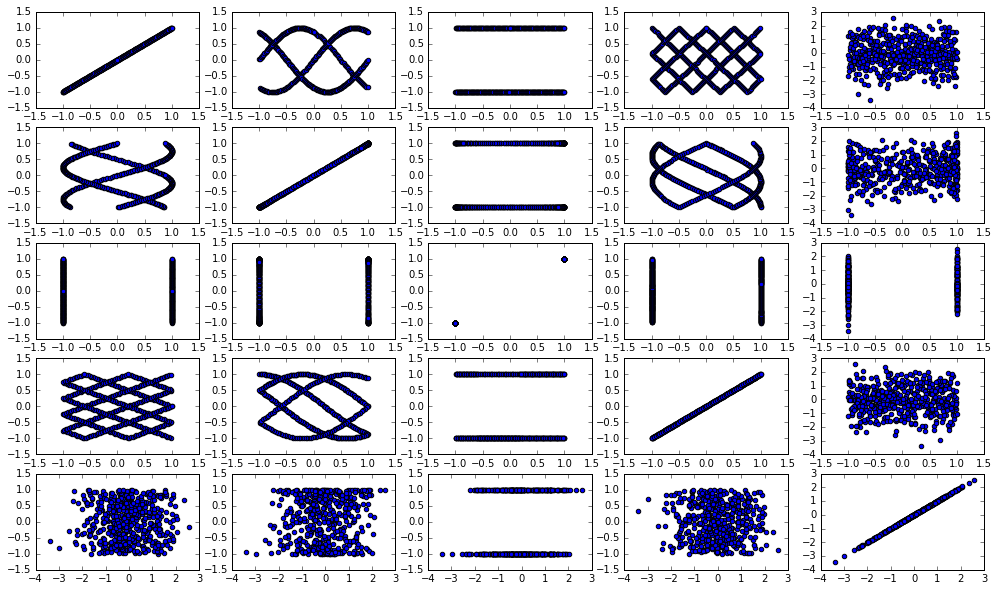

In [12]:
plot_scatter(S)

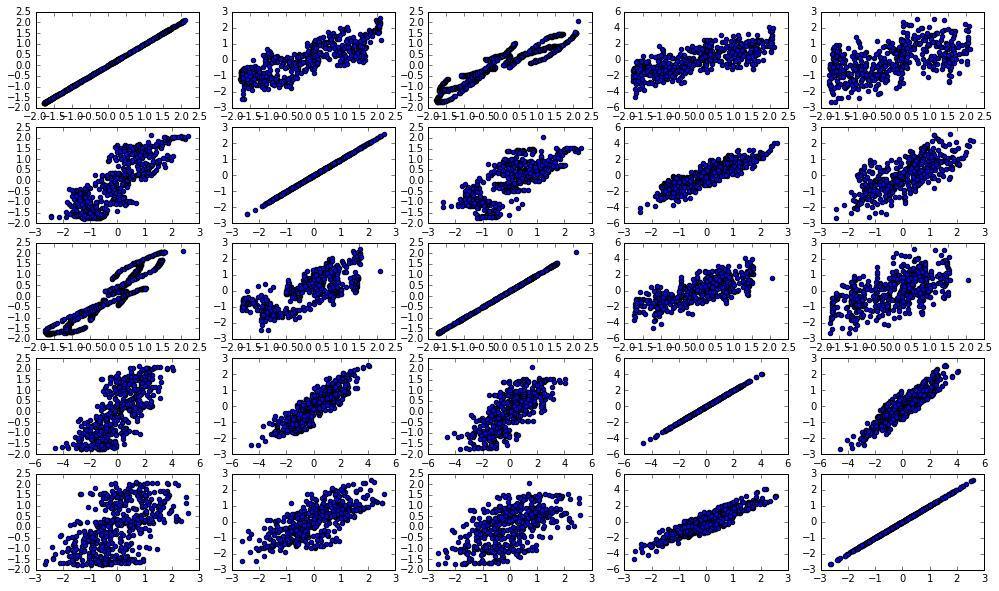

In [13]:
plot_scatter(M)

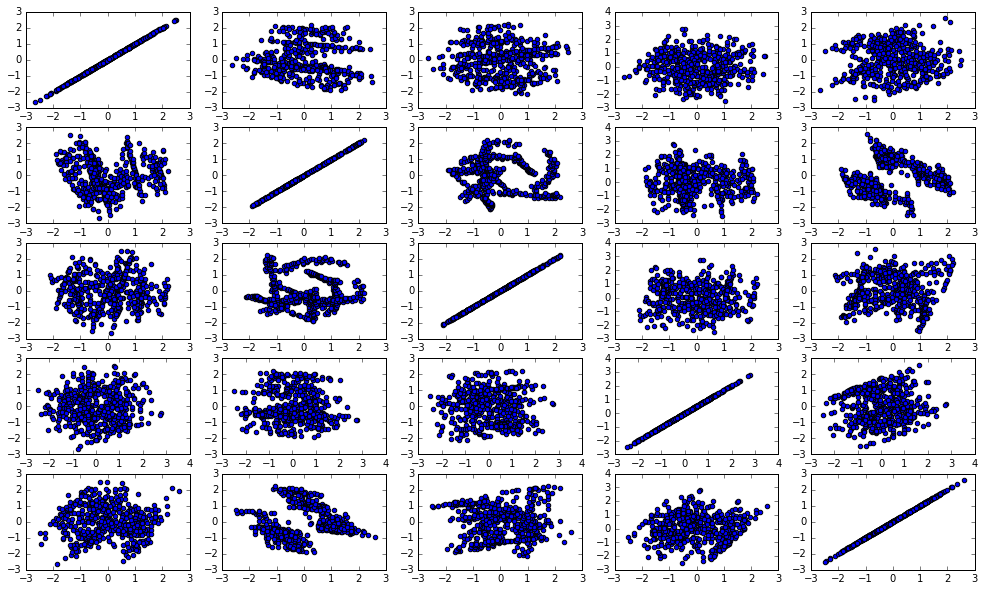

In [14]:
plot_scatter(whiten(M))

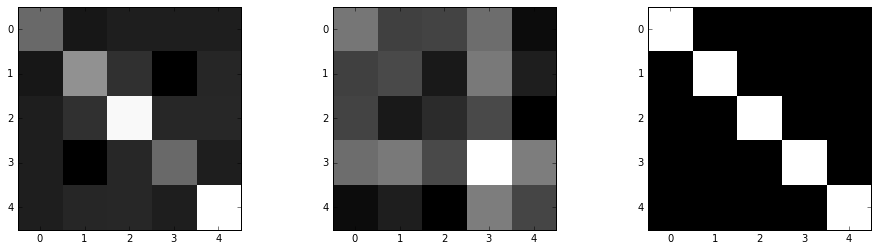

In [15]:
# Computing covariance matrices
fig = plt.figure()
fig.set_size_inches((16, 4))

cov_mats = map(np.cov, [S, M, whiten(M)])

for i, C in enumerate(cov_mats):
    ax = plt.subplot(1, len(cov_mats), i + 1)
    imshow(C, cmap='gray', interpolation='nearest')

plt.show()

### 1.6 Covariance (5 points)
Explain what a covariant algorithm is. 

### 1.7 Independent Component Analysis (25 points)
Implement the covariant ICA algorithm as described in MacKay. Write a function `ICA(X, activation_function, learning_rate)`, that returns the demixing matrix $\mathbf{W}$. The input `activation_function` should accept a function such as `lambda a: -tanh(a)`. Update the gradient in batch mode, averaging the gradients over the whole dataset for each update. Try to make it efficient, i.e. use matrix operations instead of loops where possible (loops are slow in interpreted languages such as python and matlab, whereas matrix operations are internally computed using fast C code).

In [19]:
def ICA(X, activation_function, learning_rate, niter=100):
    W = random_nonsingular_matrix(d=len(X))
    
    # Algorithm 34.4 (MacKay)
    for i in range(niter):
        # 1st step. Put X through linear mapping
        a = W.dot(X)
        # 2nd step. Put a through nonlinear mapping
        z = activation_function(a)
        # 3rd step. Put a back trough W
        x_ = W.T.dot(a)
        # 4th step. Compute derivative
        dW = W + z.dot(x_.T) / X.shape[1]

        W += learning_rate * dW
    
    return W

### 1.8 Experiments  (5 points)
Run ICA on the provided signals using each activation function $\phi_0, \ldots, \phi_3$. Plot the retreived signals for each choice of activation function.

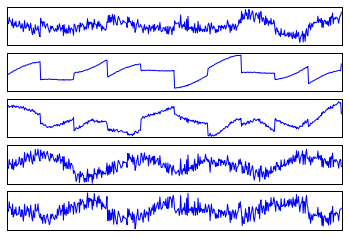

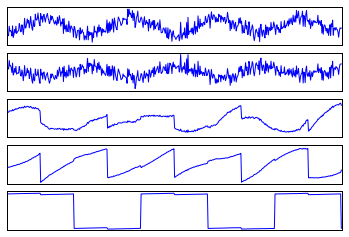

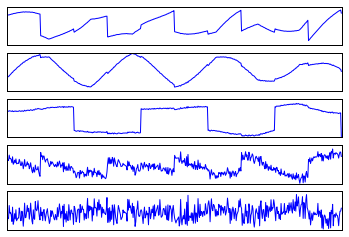

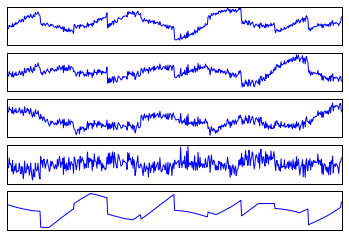

In [20]:
M_whiten = whiten(M)

for phi in activation_functions:
    W = ICA(M_whiten, phi, 0.001, niter=10000)
    plot_signals(W.dot(M_whiten))

### 1.9 Audio demixing (5 points)
The 'cocktail party effect' refers to the ability humans have to attend to one speaker in a noisy room. We will now use ICA to solve a similar but somewhat idealized version of this problem. The code below loads 5 sound files and produces 5 mixed sound files, which are saved to disk so you can listen to them. Use your ICA implementation to de-mix these and reproduce the original source signals. As in the previous exercise, try each of the activation functions and report your results.

Keep in mind that this problem is easier than the real cocktail party problem, because in real life there are often more sources than measurements (we have only two ears!), and the number of sources is unknown and variable. Also, mixing is not instantaneous in real life, because the sound from one source arrives at each ear at a different point in time. If you have time left, you can think ways to deal with these issues.

In [48]:
import scipy.io.wavfile
def save_wav(data, out_file, rate):
    scaled = np.int16(data / np.max(np.abs(data)) * 32767)
    scipy.io.wavfile.write(out_file, rate, scaled)

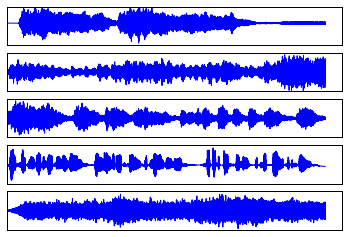

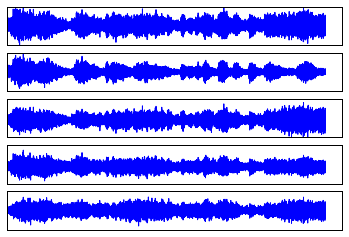

In [49]:
# Load audio sources
source_files = ['beet.wav', 'beet9.wav', 'beet92.wav', 'mike.wav', 'street.wav']
wav_data = []
sample_rate = None
for f in source_files:
    sr, data = scipy.io.wavfile.read(f, mmap=False)
    if sample_rate is None:
        sample_rate = sr
    else:
        assert(sample_rate == sr)
    wav_data.append(data[:190000])  # cut off the last part so that all signals have same length

# Create source and measurement data
S = np.c_[wav_data]
plot_signals(S)

# Requires your function make_mixtures
X = make_mixtures(S, random_nonsingular_matrix(d=len(S)))
plot_signals(X)
# Save mixtures to disk, so you can listen to them in your audio player
for i in range(X.shape[0]):
    save_wav(X[i, :], 'X' + str(i) + '.wav', sample_rate)

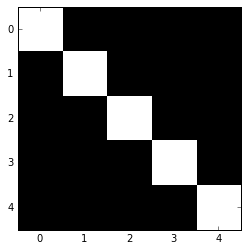

In [59]:
X_whiten = whiten(X)
imshow(np.cov(X_whiten), cmap='gray', interpolation='nearest')
plt.show()
W = ICA(X_whiten, phi0, 0.01, niter=10000)

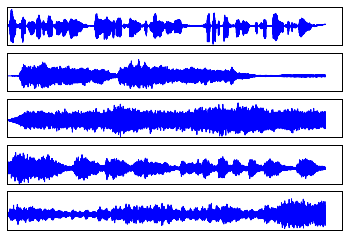

In [60]:
R = W.dot(X_whiten)
plot_signals(R)

In [61]:
for i in range(R.shape[0]):
    save_wav(R[i, :], 'R' + str(i) + '.wav', sample_rate)

### 1.10 Excess Kurtosis (20 points)
The (excess) kurtosis is a measure of 'peakedness' of a distribution. It is defined as
$$
\verb+Kurt+[X] = \frac{\mu_4}{\sigma^4} - 3 = \frac{\operatorname{E}[(X-{\mu})^4]}{(\operatorname{E}[(X-{\mu})^2])^2} - 3
$$
Here, $\mu_4$ is known as the fourth moment about the mean, and $\sigma$ is the standard deviation.
The '-3' term is introduced so that a Gaussian random variable has 0 excess kurtosis.
We will now try to understand the performance of the various activation functions by considering the kurtosis of the corresponding priors, and comparing those to the empirical kurtosis of our data.

First, compute analytically the kurtosis of the four priors that you derived from the activation functions before. To do this, you will need the normalizing constant of the distribution, which you can either obtain analytically (good practice!), using computer algebra software (e.g. Sage) or by numerical integration (see scipy.integrate).

Now use the `scipy.stats.kurtosis` function, with the `fisher` option set to `True`, to compute the empirical kurtosis of the dummy signals and the real audio signals. Can you use this data to explain the performance of the various activation functions?